# GNS Project

lib import:

In [1]:
import os
import json
import torch
import subprocess
import numpy as np
import torch_geometric as pyg
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from torch_geometric.data import Data, Batch

In [ ]:
!pip install torch-cluster
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-geometric

Download dataset if not present

In [2]:
import urllib.request

DATASET_NAME = "WaterDropSample"
OUTPUT_DIR = "temp/datasets/"

# Create main output folder if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created folder: {OUTPUT_DIR}")

# Dataset-specific path
dataset_path = os.path.join(OUTPUT_DIR, DATASET_NAME)
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    print(f"Created dataset folder: {dataset_path}")

    BASE_URL = f"https://storage.googleapis.com/learning-to-simulate-complex-physics/Datasets/{DATASET_NAME}/"
    files = ["metadata.json", "train.tfrecord", "valid.tfrecord", "test.tfrecord"]

    for file in files:
        url = f"{BASE_URL}{file}"
        out_path = os.path.join(dataset_path, file)
        print(f"Downloading {file}...")
        urllib.request.urlretrieve(url, out_path)
    print("Download complete!")
else:
    print(f"Dataset '{DATASET_NAME}' already exists at {dataset_path}")

Dataset 'WaterDropSample' already exists at temp/datasets/WaterDropSample


Data preprocessing  

Read files


In [3]:
DATASET_NAME = "WaterDropNase"

with open(f"{OUTPUT_DIR}/{DATASET_NAME}/metadata.json") as f:
    metadata = json.load(f)

with open(f"{OUTPUT_DIR}/{DATASET_NAME}/valid_offset.json") as f:
    offsets = json.load(f)
offsets = {int(k): v for k, v in offsets.items()}

particle_type_mmap = np.memmap(f"{OUTPUT_DIR}/{DATASET_NAME}/valid_particle_type.dat", dtype=np.int64, mode="r")
position_type_mmap = np.memmap(f"{OUTPUT_DIR}/{DATASET_NAME}/valid_position.dat", dtype=np.float32, mode="r")


In [4]:
trajectory_id = 0  
trajectory = offsets[trajectory_id]

T, N, D = trajectory["position"]["shape"]  
ptype = particle_type_mmap[trajectory["particle_type"]["offset"] : trajectory["particle_type"]["offset"] + N].copy()
position = position_type_mmap[trajectory["position"]["offset"] : trajectory["position"]["offset"] + (T * N * D)].copy()
position = position.reshape(T, N, D)  

print(f"Loaded trajectory #{trajectory_id}: T = {T}, N = {N}, D = {D}")
print("Particle types present:", np.unique(ptype))
print("Bounds:", metadata['bounds'])

Loaded trajectory #0: T = 70, N = 393, D = 2
Particle types present: [0]
Bounds: [[0.02710752934217453, 0.9590740203857422], [0.025763114914298058, 0.9568175673484802]]


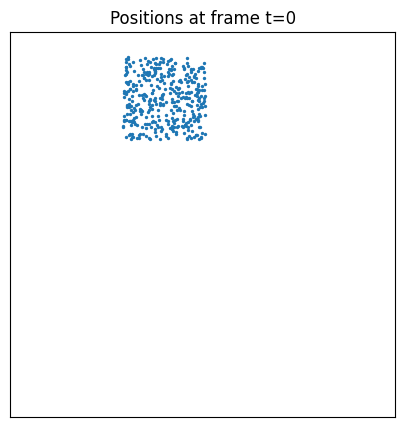

In [5]:
t_0 = 0
plt.figure(figsize=(5,5))
bounds = metadata["bounds"]
plt.xlim(bounds[0][0], bounds[0][1]); plt.ylim(bounds[1][0], bounds[1][1])
plt.gca().set_aspect(1.0)
plt.scatter(position[t_0, :, 0], position[t_0, :, 1], s=2)
plt.title(f"Positions at frame t={t_0}")
plt.xticks([]); plt.yticks([])
plt.show()


max_frames = min(1000, T)
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_xlim(bounds[0][0], bounds[0][1])
ax.set_ylim(bounds[1][0], bounds[1][1])
ax.set_aspect(1.0); ax.set_xticks([]); ax.set_yticks([])
sc = ax.plot([], [], "o", ms = 2)[0]
ax.set_title("Trajectory (simuliraj)")

def init():
    sc.set_data([], [])
    return (sc,)

def update(frame):
    sc.set_data(position[frame, :, 0], position[frame, :, 1])
    return (sc,)

anim = animation.FuncAnimation(fig, update, init_func = init, frames = max_frames, interval = 10, blit = True)
plt.close(fig)
HTML(anim.to_html5_video())


## GNS model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


Graph structure:

In [7]:
class Graph:
    def __init__(self, nodes, edges, senders, receivers, globals=None):
        self.nodes = nodes         #[N, node_dim]
        self.edges = edges         #[E, edge_dim]
        self.senders = senders     #[E] long
        self.receivers = receivers #[E] long
        self.globals = globals #global graph feature

    def to(self, device):
        self.nodes = self.nodes.to(device)
        self.edges = self.edges.to(device)
        self.senders = self.senders.to(device).long()
        self.receivers = self.receivers.to(device).long()
        if self.globals is not None:
            self.globals = self.globals.to(device)
        return self

In [8]:
def build_graph_knn(position_t, k=16):
    nodes = torch.tensor(position_t, dtype=torch.float32)
    N, D = nodes.shape
    #compute pairwise distances
    with torch.no_grad():
        d = torch.cdist(nodes, nodes)
        d.fill_diagonal_(float('inf'))
        knn = torch.topk(d, k=k, largest=False).indices

    senders = []
    receivers = []
    for i in range(N):
        for j in knn[i].tolist():
            senders.append(i)
            receivers.append(int(j))
    senders = torch.tensor(senders, dtype=torch.long)
    receivers = torch.tensor(receivers, dtype=torch.long)
    edges = nodes[receivers] - nodes[senders]  #relative positions
    return Graph(nodes, edges, senders, receivers)


The encoding, processing and decoding happens with this block and forms the message passing. It needs a lot more features that are included in the paper.

In [9]:
import torch.nn as nn

class EPDBlock(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super().__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim) 
        )

    def forward(self, graph: Graph):
        sender_nodes = graph.nodes[graph.senders]     #[E, node_dim]
        receiver_nodes = graph.nodes[graph.receivers] #[E, node_dim]
        edges_feat = graph.edges                      #[E, edge_dim]

        edge_input = torch.cat([sender_nodes, receiver_nodes, edges_feat], dim=1)  #[E, 2*node_dim + edge_dim]
        messages = self.edge_mlp(edge_input)  #[E, hidden_dim]

        #aggregated per receiver: need [N, hidden_dim]
        N = graph.nodes.size(0)
        hidden_dim = messages.size(1)
        aggregated = torch.zeros((N, hidden_dim), device=graph.nodes.device, dtype=messages.dtype)
        aggregated.index_add_(0, graph.receivers, messages)


        node_input = torch.cat([graph.nodes, aggregated], dim=1)  #[N, node_dim + hidden_dim]
        updated_nodes = self.node_mlp(node_input)  #[N, node_dim]
        graph.nodes = updated_nodes
        return graph

    

In [10]:
class Simulator(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, num_blocks=2):
        super().__init__()
        self.blocks = nn.ModuleList([
            EPDBlock(node_dim, edge_dim, hidden_dim) for _ in range(num_blocks)
        ])

    def forward(self, graph: Graph):
        for block in self.blocks:
            graph = block(graph)
        return graph
    

Node features

In [11]:
num_types = int(np.max(ptype)) + 1
type_dim = 4
type_embed = nn.Embedding(num_types, type_dim).to(device)

def prepare_nodes(pos_prev, pos_curr, ptype):
    pos_prev_t = torch.tensor(pos_prev, dtype=torch.float32).to(device)
    pos_curr_t = torch.tensor(pos_curr, dtype=torch.float32).to(device)
    velocity_t = pos_curr_t - pos_prev_t
    type_t = type_embed(torch.tensor(ptype, dtype=torch.long).to(device))
    nodes = torch.cat([pos_prev_t, velocity_t, type_t], dim=1)
    return nodes

Training 1 step prediction

In [12]:
node_dim = 2 + 2 + type_dim  # pos + vel + type
edge_dim = 2                 # relative position
hidden_dim = 64
simulator = Simulator(node_dim, edge_dim, hidden_dim, num_blocks=3).to(device)
opt = torch.optim.Adam(simulator.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()

In [14]:
EPOCHS = 150 
for e in range(EPOCHS): 
    total_loss = 0.0 
    for t in range(1, T-1):
        nodes = prepare_nodes(position[t-1], position[t], ptype) 
        graph = build_graph_knn(position[t-1], k=16) 
        graph.nodes = nodes
        graph = graph.to(device) 

        graph_next = simulator(graph) 
        target = torch.tensor(position[t+1], dtype=torch.float32).to(device) 
        
        loss = loss_fn(graph_next.nodes[:, :2], target)
        opt.zero_grad() 
        loss.backward() 
        opt.step() 
        total_loss += loss.item() 
    print(f"Epoch {e+1}/{EPOCHS}, Loss: {total_loss/(T-2):.6f}")

Epoch 1/150, Loss: 0.005596
Epoch 2/150, Loss: 0.006549
Epoch 3/150, Loss: 0.007839
Epoch 4/150, Loss: 0.007061
Epoch 5/150, Loss: 0.006978
Epoch 6/150, Loss: 0.003773
Epoch 7/150, Loss: 0.003971
Epoch 8/150, Loss: 0.005045
Epoch 9/150, Loss: 0.005829
Epoch 10/150, Loss: 0.003625
Epoch 11/150, Loss: 0.003403
Epoch 12/150, Loss: 0.003237
Epoch 13/150, Loss: 0.002837
Epoch 14/150, Loss: 0.003444
Epoch 15/150, Loss: 0.004996
Epoch 16/150, Loss: 0.002288
Epoch 17/150, Loss: 0.002311
Epoch 18/150, Loss: 0.001836
Epoch 19/150, Loss: 0.001896
Epoch 20/150, Loss: 0.001898
Epoch 21/150, Loss: 0.001448
Epoch 22/150, Loss: 0.001890
Epoch 23/150, Loss: 0.001882
Epoch 24/150, Loss: 0.001060
Epoch 25/150, Loss: 0.001364
Epoch 26/150, Loss: 0.000975
Epoch 27/150, Loss: 0.000925
Epoch 28/150, Loss: 0.001056
Epoch 29/150, Loss: 0.001230
Epoch 30/150, Loss: 0.001000
Epoch 31/150, Loss: 0.000965
Epoch 32/150, Loss: 0.001052
Epoch 33/150, Loss: 0.000708
Epoch 34/150, Loss: 0.000712
Epoch 35/150, Loss: 0.0

In [15]:
def gns_rollout(simulator, positions, ptype, t0=0, alpha=0.9):
    T, N, D = positions.shape
    pred_positions = [positions[t0]]

    for t in range(t0+1, T-1):
        nodes = prepare_nodes(pred_positions[-1], positions[t], ptype)
        graph = build_graph_knn(pred_positions[-1], k=16)
        graph.nodes = nodes
        graph = graph.to(device)
        graph_next = simulator(graph)

        #gradual smoothing
        pred_next = graph_next.nodes[:, :2].detach().cpu().numpy()
        pred_smoothed = alpha * pred_next + (1 - alpha) * pred_positions[-1]
        pred_positions.append(pred_smoothed)

    return np.stack(pred_positions, axis=0)



pred_full = gns_rollout(simulator, position, ptype, alpha=0.9)
gt_full = position.copy()

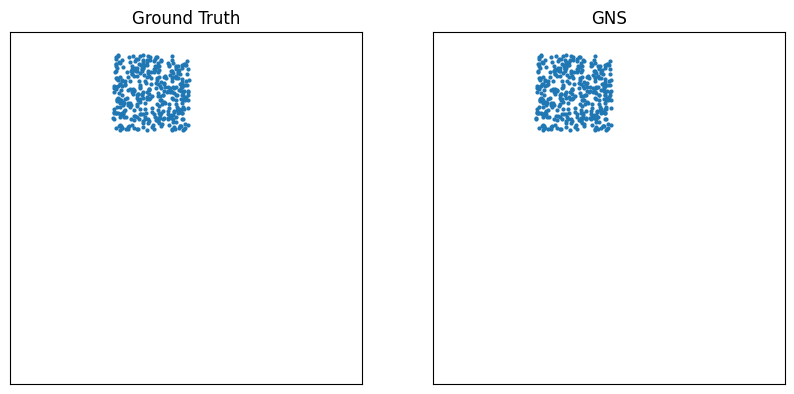

In [16]:
def animate_pair(p_gt, p_pred, bounds, step = 1, max_frames = 400, title_gt="Ground Truth", title_pr="GNS"):
    if p_gt.ndim == 2: 
        p_gt = p_gt[None, ...]
    if p_pred.ndim == 2: 
        p_pred = p_pred[None, ...]
    K = p_gt.shape[0]
    frames = list(range(0, min(max_frames, K), max(1, step)))
    t_0 = 0
    _, axes0 = plt.subplots(1, 2, figsize=(10, 5))
    for ax, title in zip(axes0, [title_gt, title_pr]):
        ax.set_xlim(bounds[0][0], bounds[0][1])
        ax.set_ylim(bounds[1][0], bounds[1][1])
        ax.set_aspect(1.0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)
    axes0[0].plot(p_gt[t_0, :, 0],  p_gt[t_0, :, 1],  "o", ms = 2)
    axes0[1].plot(p_pred[t_0, :, 0], p_pred[t_0, :, 1], "o", ms = 2)
    plt.show()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax, title in zip(axes, [title_gt, title_pr]):
        ax.set_xlim(bounds[0][0], bounds[0][1])
        ax.set_ylim(bounds[1][0], bounds[1][1])
        ax.set_aspect(1.0); ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(title)
    sc_gt = axes[0].plot([], [], "o", ms = 2)[0]
    sc_pr = axes[1].plot([], [], "o", ms = 2)[0]
    def init():
        sc_gt.set_data([], [])
        sc_pr.set_data([], [])
        return (sc_gt, sc_pr)

    def update(frame_idx):
        sc_gt.set_data(p_gt[frame_idx, :, 0],  p_gt[frame_idx, :, 1])
        sc_pr.set_data(p_pred[frame_idx, :, 0], p_pred[frame_idx, :, 1])
        return (sc_gt, sc_pr)

    anim = animation.FuncAnimation(fig, update, init_func = init, frames = frames, interval = 10, blit = True)
    plt.close(fig)
    return HTML(anim.to_html5_video())
animate_pair(gt_full, pred_full, metadata["bounds"], step = 2, max_frames = 1000)